# SARIMA

Notes:  
1. Analysis on "中国石化 600028.SH".

## Load Necessary Packages

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import os, math, warnings, time

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tools.sm_exceptions import InterpolationWarning
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima
from statsmodels.stats.stattools import jarque_bera
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import jarque_bera, skew, kurtosis
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima.model import ARIMA                   
from statsmodels.tsa.statespace.sarimax import SARIMAX          
from statsmodels.tsa.stattools import acf                       
warnings.filterwarnings("ignore")

# Data Preparation

In [6]:
# Load CSV file (replace with your path if needed)
file_path = "data/single_stock_data_1/600028.csv"
df = pd.read_csv(file_path)

# Ensure datetime index
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df = df.set_index('Date')

# Build complete time series on close price
ts = df['close']



## Data Visualization

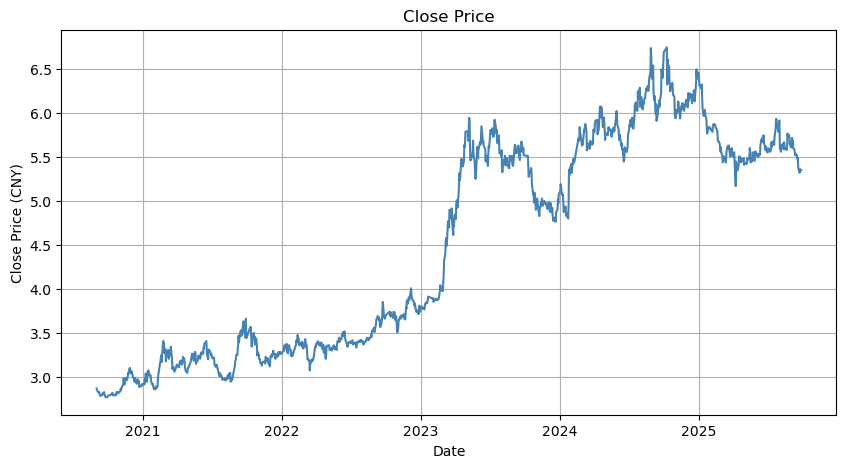

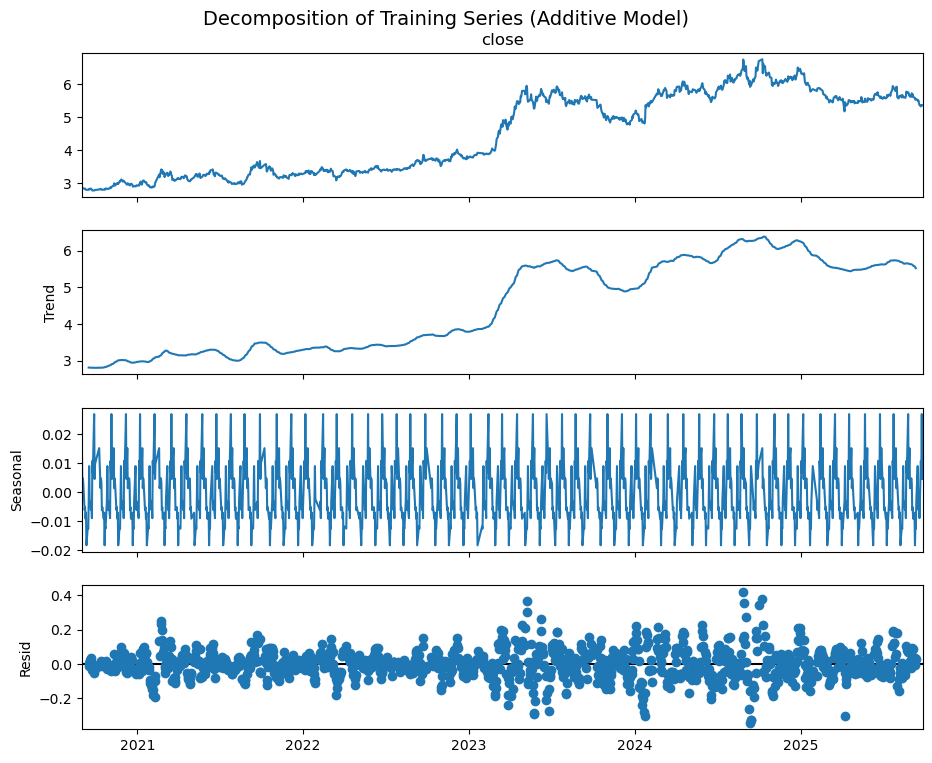

In [8]:
# Plot time series
plt.figure(figsize=(10, 5))
plt.plot(ts, color='steelblue')
plt.title("Close Price")
plt.xlabel("Date")
plt.ylabel("Close Price (CNY)")
plt.grid(True)
plt.show()

# --- Decomposition ---
# period: approximate trading month (22 days), can be tuned later
decomp_result = seasonal_decompose(ts, model='additive', period=22)

# Plot the decomposition
fig = decomp_result.plot()
fig.set_size_inches(10, 8)
fig.suptitle("Decomposition of Training Series (Additive Model)", fontsize=14)
plt.show()

## Stationarity Test

In [10]:
# suppress only InterpolationWarning
warnings.simplefilter("ignore", InterpolationWarning)

# --- ADF Test ---
def adf_test(series):
    adf_result = adfuller(series, autolag='AIC')
    print("ADF Statistic:", adf_result[0])
    print("p-value:", adf_result[1])
    print("Critical Values:", adf_result[4])
    if adf_result[1] < 0.05:
        print("Reject H0: Series is stationary")
        return True
    else:
        print("Fail to reject H0: Series is non-stationary")
        return False


# --- KPSS Test ---
def kpss_test(series):
    kpss_result = kpss(series, regression='c', nlags='auto')  # 'c' for level, 'ct' for trend
    print("\nKPSS Statistic:", kpss_result[0])
    print("p-value:", kpss_result[1])
    print("Critical Values:", kpss_result[3])
    if kpss_result[1] < 0.05:
        print("Reject H0: Series is non-stationary")
        return False
    else:
        print("Fail to reject H0: Series is stationary")
        return True

## Stationarity Test before transformation

In [12]:
adf_test(ts)
kpss_test(ts)

ADF Statistic: -1.29226919001992
p-value: 0.6327017050111334
Critical Values: {'1%': -3.435690695421723, '5%': -2.863898416697677, '10%': -2.5680256555204184}
Fail to reject H0: Series is non-stationary

KPSS Statistic: 5.392931361009262
p-value: 0.01
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Reject H0: Series is non-stationary


False

## Data transformation: differencing, take log, etc.

In [14]:
def transform_log(series):
    """
    对数
    """
    transformed = np.log(series)
    
    plt.figure(figsize=(10,4))
    plt.plot(transformed, color="orange")
    plt.title(f"Transformed Series (Log)")
    plt.xlabel("Date"); plt.ylabel("Value"); plt.tight_layout(); plt.show()
    
    return transformed

def transform_1stdiff(series):
    """
    一阶差分
    """
    transformed = series.diff().dropna()
    
    plt.figure(figsize=(10,4))
    plt.plot(transformed, color="orange")
    plt.title(f"Transformed Series (1st Diff)")
    plt.xlabel("Date"); plt.ylabel("Value"); plt.tight_layout(); plt.show()
    
    return transformed



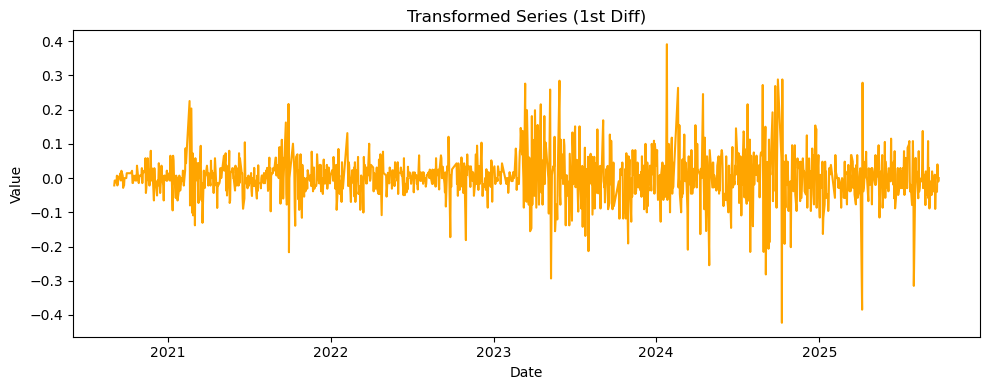

In [15]:
# Do transformation on both train and test.
# ts_log = transform_log(ts)
ts_1stdiff = transform_1stdiff(ts)
# ts_log_1stdiff = transform_1stdiff(ts_log)


## Stationarity Test after transformation

In [17]:
adf_test(ts_1stdiff)
kpss_test(ts_1stdiff)



ADF Statistic: -16.96129005938974
p-value: 9.304247995922117e-30
Critical Values: {'1%': -3.435690695421723, '5%': -2.863898416697677, '10%': -2.5680256555204184}
Reject H0: Series is stationary

KPSS Statistic: 0.11956658074387824
p-value: 0.1
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Fail to reject H0: Series is stationary


True

## Data Splitting

In [19]:
# --- Split into training and test sets ---
split_ratio = 0.8  # 80% train, 20% test
split_index = int(len(ts_1stdiff) * split_ratio)

train = ts_1stdiff.iloc[:split_index]
test = ts_1stdiff.iloc[split_index:]

## Plot ACF and PACF

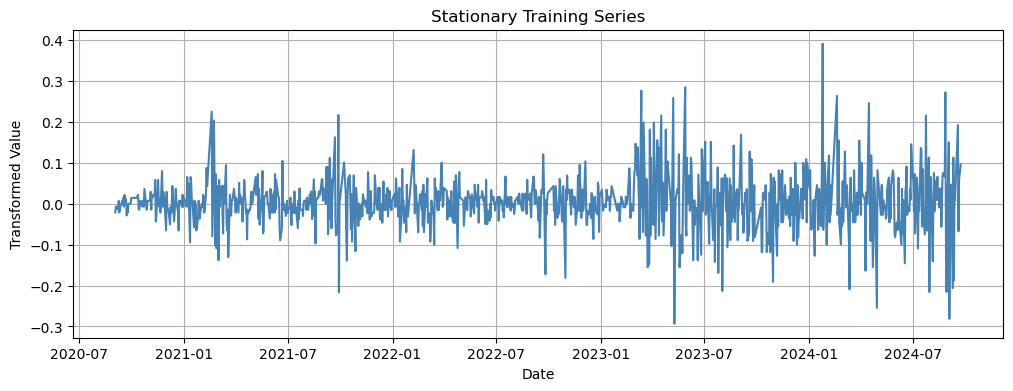

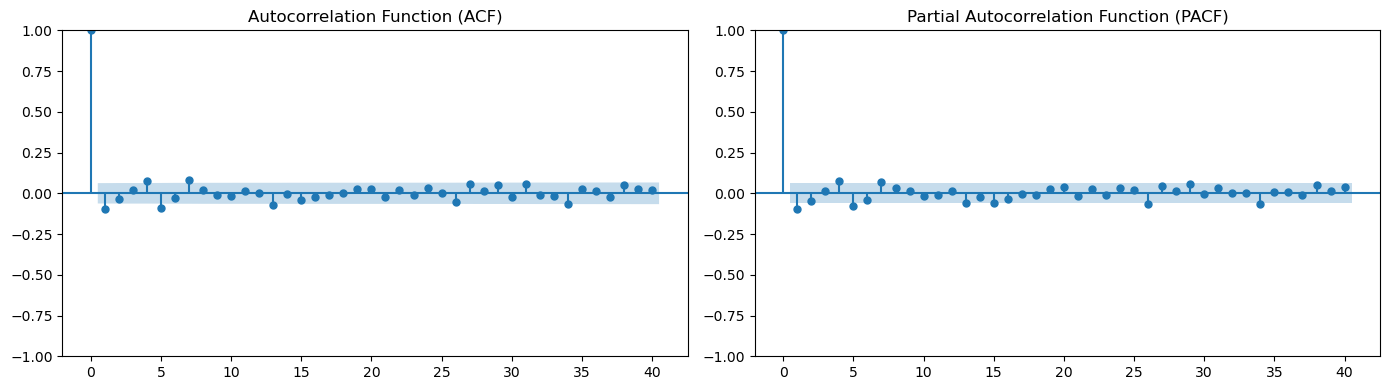

In [21]:
plt.figure(figsize=(12, 4))
plt.plot(train, color='steelblue')
plt.title("Stationary Training Series")
plt.xlabel("Date")
plt.ylabel("Transformed Value")
plt.grid(True)
plt.show()

# --- Plot ACF and PACF ---
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

plot_acf(train, lags=40, ax=axes[0])
axes[0].set_title("Autocorrelation Function (ACF)")

plot_pacf(train, lags=40, ax=axes[1], method='ywm')
axes[1].set_title("Partial Autocorrelation Function (PACF)")

plt.tight_layout()
plt.show()

## Building the ARIMA Model

Both ACF and PACF decay gradually (no clear cutoff), so we consider ARMA model (p, q != 0). To avoid overfitting, we choose p, q to be values less than 3. Therefore, we have candidates drawn from ACF, PACF:  
1. ARMA(1,1)  
2. ARMA(2,2)  
3. ARMA(1,2)  
4. ARMA(2,1)

In [24]:


pd.set_option("display.float_format", lambda x: f"{x:,.6f}")

# ---- 原 ARIMA 搜索网格 ----
P_RANGE_AR = range(0, 3)   # p ∈ {0,1,2}
D_LIST_AR = [0]            # d = 0（数据已stational）
Q_RANGE_AR = range(0, 3)   # q ∈ {0,1,2}

# ---- 新：SARIMA 搜索网格（小网格，跑得快；想更细可放大范围）----
P_RANGE_SEA = range(0, 3)  # 季节 AR 阶 P ∈ {0,1,2}
D_LIST_SEA  = [0,1]       # 季节差分 D ∈ {0,1}
Q_RANGE_SEA = range(0, 3)  # 季节 MA 阶 Q ∈ {0,1,2}

# 候选季节周期（交易日）：5=周周期（月内工作日），20≈月，60≈季
SEASONALITY_CANDIDATES = [5, 20, 60]

# 组合评分权重
W_RMSE, W_MAE, W_R2 = 0.4, 0.3, 0.3

# 限时预算
TIME_BUDGET_PER_SERIES = 1.5


# =========================================================
# 季节周期探测
# =========================================================
def infer_candidate_seasons(y: pd.Series, max_lag=90, top_k=2):
    """
    返回若干个可能的季节周期（如 5, 20, 60），用于与 SEASONALITY_CANDIDATES 交叉。
    方法很轻量：用 ACF 找到除1阶以外的若干局部峰，过滤掉太小的峰。
    """
    y = pd.Series(y).astype(float).dropna()
    if len(y) < 30:
        return []  # 太短就不猜

    # 计算 ACF（含 lag=0），取 1..max_lag
    acf_vals = acf(y, nlags=min(max_lag, len(y) // 2), fft=True)
    lags = np.arange(len(acf_vals))

    # 简单找局部峰（忽略 lag=0）
    peak_lags = []
    for k in range(2, len(acf_vals) - 1):  # 从2开始避开 lag=0,1
        if acf_vals[k] > acf_vals[k-1] and acf_vals[k] > acf_vals[k+1]:
            peak_lags.append((lags[k], acf_vals[k]))

    # 过滤：相关性阈值
    peak_lags = [(lag, v) for lag, v in peak_lags if v >= 0.1]
    # 排序并取前 top_k
    peak_lags.sort(key=lambda x: x[1], reverse=True)
    inferred = [int(lag) for lag, _ in peak_lags[:top_k]]
    # 去掉太小的 lag
    inferred = [s for s in inferred if s >= 3]
    return inferred


# =========================================================
# SARIMA 搜索（以最小 AICc 为准）
# =========================================================
def fit_best_sarima(
    y: pd.Series,
    p_range, d_list, q_range,
    P_range, D_list, Q_range,
    seasons: list,
    time_budget=None
):
    """
    在给定候选季节周期 s ∈ seasons 下搜索 (p,d,q)×(P,D,Q,s)，
    以 AICc 最小作为“最优”，并受 time_budget 限制。
    """
    start = time.time()
    best = {"model": None, "order": None, "seasonal_order": None, "aic": np.inf, "s": None}
    
    n = len(y)

    # 若 seasons 为空，直接兜底返回 (非季节模型)
    if not seasons:
        try:
            m = SARIMAX(y, order=(0, 0, 0), seasonal_order=(0, 0, 0, 0),
                        enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
            return m, (0, 0, 0), (0, 0, 0, 0), float(m.aic)
        except Exception:
            pass
        # 再兜底
        m = ARIMA(y, order=(0, 0, 0)).fit()
        return m, (0, 0, 0), (0, 0, 0, 0), float(m.aic)

    for s in seasons:
        for p in p_range:
            for d in d_list:
                for q in q_range:
                    for P in P_range:
                        for D in D_list:
                            for Q in Q_range:
                                # 限时控制
                                if time_budget and (time.time() - start) > time_budget:
                                    if best["model"] is None:
                                        # SARIMA
                                        try:
                                            m = SARIMAX(y, order=(0,0,0), seasonal_order=(0,0,0,s),
                                                        enforce_stationarity=False,
                                                        enforce_invertibility=False).fit(disp=False)
                                            # 计算AICc
                                            k = int(m.df_model + 1)
                                            aic = float(m.aic)
                                            aicc = aic + (2 * k * (k + 1)) / max(n - k - 1, 1)
                                            return m, (0,0,0), (0,0,0,s), float(aicc)
                                        except Exception:
                                            m = ARIMA(y, order=(0,0,0)).fit()
                                            return m, (0,0,0), (0,0,0,s), float(aicc)
                                    return best["model"], best["order"], best["seasonal_order"], float(best["aicc"])

                                try:
                                    m = SARIMAX(
                                        y,
                                        order=(p, d, q),
                                        seasonal_order=(P, D, Q, s),
                                        enforce_stationarity=False,
                                        enforce_invertibility=False
                                    ).fit(disp=False)
                                    aic = float(m.aic)
                                    k = int(m.df_model + 1)
                                    aicc = aic + (2 * k * (k + 1)) / max(n - k - 1, 1)
                                    if aicc < best["aicc"]:
                                        best = {
                                            "model": m,
                                            "order": (p, d, q),
                                            "seasonal_order": (P, D, Q, s),
                                            "aicc": aicc,
                                            "s": s
                                        }
                                except Exception:
                                    continue

    if best["model"] is None:
        # 兜底
        try:
            m = SARIMAX(y, order=(0,0,0), seasonal_order=(0,0,0,seasons[0]),
                        enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
            k = int(m.df_model + 1)
            aic = float(m.aic)
            aicc = aic + (2 * k * (k + 1)) / max(n - k - 1, 1)
            return m, (0,0,0), (0,0,0,seasons[0]), float(aicc)
        except Exception:
            m = ARIMA(y, order=(0,0,0)).fit()
            k = int(m.df_model + 1)
            aic = float(m.aic)
            aicc = aic + (2 * k * (k + 1)) / max(n - k - 1, 1)
            return m, (0,0,0), (0,0,0,seasons[0]), float(aicc)

    return best["model"], best["order"], best["seasonal_order"], float(best["aicc"])


# =========================================================
# ARIMA 搜索函数（以最小 AICc 为准）
# =========================================================
def fit_best_arima(y, p_range, d_list, q_range, time_budget=None):
    start = time.time()
    best = {"model": None, "order": None, "aicc": np.inf}

    n = len(y)

    for p in p_range:
        for d in d_list:
            for q in q_range:
                # 时间预算控制
                if time_budget and (time.time() - start) > time_budget:
                    if best["model"] is None:
                        m = ARIMA(y, order=(0,0,0)).fit()
                        # 计算AICc
                        k = int(m.df_model + 1)
                        aic = float(m.aic)
                        aicc = aic + (2 * k * (k + 1)) / max(n - k - 1, 1)
                        return m, (0,0,0), float(aicc)
                    return best["model"], best["order"], float(best["aicc"])

                try:
                    # 拟合模型
                    m = ARIMA(y, order=(p, d, q),
                              enforce_stationarity=False,
                              enforce_invertibility=False).fit()

                    aic = float(m.aic)
                    k = int(m.df_model + 1)
                    aicc = aic + (2 * k * (k + 1)) / max(n - k - 1, 1)

                    # 判断是否更优
                    if aicc < best["aicc"]:
                        best = {"model": m, "order": (p, d, q), "aicc": aicc}

                except Exception:
                    continue

    # 如果全部失败，则兜底
    if best["model"] is None:
        m = ARIMA(y, order=(0,0,0)).fit()
        k = int(m.df_model + 1)
        aic = float(m.aic)
        aicc = aic + (2 * k * (k + 1)) / max(n - k - 1, 1)
        return m, (0,0,0), float(aicc)

    return best["model"], best["order"], float(best["aicc"])

# =========================================================
# 归一化 & 评分
# =========================================================
def minmax_norm(s):
    s = s.astype(float)
    lo, hi = s.min(skipna=True), s.max(skipna=True)
    return (s - lo) / (hi - lo + 1e-12)
    
y_train = train.dropna().astype(float)
y_test  = test.dropna().astype(float)

records_arima = []
records_sarima = []
failed_arima, failed_sarima = [], []

print("\n 正在拟合 SARIMA 模型...")

try:
    # 自动推断季节周期
    inferred = infer_candidate_seasons(y_train, max_lag=90, top_k=2)
    s_list = list(dict.fromkeys(SEASONALITY_CANDIDATES + inferred))  # 合并去重

    model_sarima, order_s, seasonal_order_s, aicc_s = fit_best_sarima(
        y_train,
        p_range=P_RANGE_AR, d_list=D_LIST_AR, q_range=Q_RANGE_AR,
        P_range=P_RANGE_SEA, D_list=D_LIST_SEA, Q_range=Q_RANGE_SEA,
        seasons=s_list,
        time_budget=TIME_BUDGET_PER_SERIES
    )

    fc_s = model_sarima.get_forecast(steps=len(y_test)).predicted_mean
    fc_s.index = y_test.index

    rmse_s = float(np.sqrt(mean_squared_error(y_test, fc_s)))
    mae_s  = float(mean_absolute_error(y_test, fc_s))
    r2_s   = float(r2_score(y_test, fc_s))
    aic_s  = float(model_sarima.aic)
    bic_s  = float(model_sarima.bic)
    n_s    = len(y_train)
    k_s    = int(model_sarima.df_model + 1)  # 参数个数

    records_sarima.append({
        "model": "SARIMA",
        "order": str(order_s),
        "seasonal_order": str(seasonal_order_s),
        "aic": aic_s,
        "bic": bic_s,
        "aicc": aicc_s,
        "test_RMSE": rmse_s,
        "test_MAE": mae_s,
        "test_R2": r2_s
    })

    print(f"SARIMA 完成：order={order_s}, seasonal={seasonal_order_s}, "
          f"AIC={aic_s:.2f}, BIC={bic_s:.2f}, AICC={aicc_s:.2f}")

except Exception as e:
    failed_sarima.append(str(e)[:180])
    print(f"SARIMA 拟合失败: {e}")


print("\n 正在拟合 ARIMA 模型...")

try:
    model_arima, order_a, aicc_a = fit_best_arima(
        y_train,
        p_range=P_RANGE_AR,
        d_list=D_LIST_AR,
        q_range=Q_RANGE_AR,
        time_budget=TIME_BUDGET_PER_SERIES
    )

    fc_a = model_arima.get_forecast(steps=len(y_test)).predicted_mean
    fc_a.index = y_test.index

    rmse_a = float(np.sqrt(mean_squared_error(y_test, fc_a)))
    mae_a  = float(mean_absolute_error(y_test, fc_a))
    r2_a   = float(r2_score(y_test, fc_a))
    aic_a  = float(model_arima.bic)
    bic_a  = float(model_arima.bic)
    n_a    = len(y_train)
    k_a    = int(model_arima.df_model + 1)
    
    records_arima.append({
        "model": "ARIMA",
        "order": str(order_a),
        "aic": aic_a,
        "bic": bic_a,
        "aicc": aicc_a,
        "test_RMSE": rmse_a,
        "test_MAE": mae_a,
        "test_R2": r2_a
    })

    print(f"ARIMA 完成：order={order_a}, "
          f"AIC={aic_a:.2f}, BIC={bic_a:.2f}, AICC={aicc_a:.2f}")

except Exception as e:
    failed_arima.append(str(e)[:180])
    print(f"ARIMA 拟合失败: {e}")



# ---------- 结果整理 ----------
summary_sarima = pd.DataFrame(records_sarima)
summary_arima  = pd.DataFrame(records_arima)

if not summary_sarima.empty:
    summary_sarima["CompositeScore"] = (1 - minmax_norm(summary_arima["test_RMSE"])) * W_RMSE \
                                     + (1 - minmax_norm(summary_arima["test_MAE"]))  * W_MAE \
                                    + (minmax_norm(summary_arima["test_R2"]))       * W_R2
    print("\n===== SARIMA 结果 =====")
    print(summary_sarima[["model", "order", "seasonal_order", "aic", "bic", "aicc",
                          "test_RMSE", "test_MAE", "test_R2", "CompositeScore"]].to_string(index=False))

else:
    print("\n[SARIMA] 无有效结果。")

if not summary_arima.empty:
    summary_arima["CompositeScore"] = (1 - minmax_norm(summary_arima["test_RMSE"])) * W_RMSE \
                                    + (1 - minmax_norm(summary_arima["test_MAE"]))  * W_MAE \
                                    + (minmax_norm(summary_arima["test_R2"]))       * W_R2
    print("\n===== ARIMA 结果 =====")
    print(summary_arima[["model", "order", "aic", "bic", "aicc",
                         "test_RMSE", "test_MAE", "test_R2", "CompositeScore"]].to_string(index=False))

else:
    print("\n[ARIMA] 无有效结果。")



 正在拟合 SARIMA 模型...
SARIMA 完成：order=(0, 0, 0), seasonal=(0, 0, 0, 5), AIC=-2547.00, BIC=-2542.11, AICC=-2546.99

 正在拟合 ARIMA 模型...
ARIMA 完成：order=(1, 0, 0), AIC=-2540.04, BIC=-2540.04, AICC=-2554.67

===== SARIMA 结果 =====
 model     order seasonal_order           aic           bic          aicc  test_RMSE  test_MAE   test_R2  CompositeScore
SARIMA (0, 0, 0)   (0, 0, 0, 5) -2,547.002340 -2,542.111731 -2,546.990108   0.078368  0.051896 -0.002055        0.700000

===== ARIMA 结果 =====
model     order           aic           bic          aicc  test_RMSE  test_MAE   test_R2  CompositeScore
ARIMA (1, 0, 0) -2,540.035063 -2,540.035063 -2,554.666033   0.078722  0.052448 -0.011138        0.700000


In [25]:
print("\n 正在拟合 ARIMA 模型（指定参数）...")

# 手动设定的 (p,d,q) 参数组合
MANUAL_ARIMA_ORDERS = [
    (1, 0, 1),
    (2, 0, 2),
    (1, 0, 2),
    (2, 0, 1)
]

records_arima = []
failed_arima = []

for order in MANUAL_ARIMA_ORDERS:
    try:
        print(f"→ 正在测试 ARIMA{order} ...")

        m = ARIMA(
            y_train,
            order=order,
            enforce_stationarity=False,
            enforce_invertibility=False
        ).fit()

        # 预测
        fc = m.get_forecast(steps=len(y_test)).predicted_mean
        fc.index = y_test.index

        # 计算误差指标
        rmse = float(np.sqrt(mean_squared_error(y_test, fc)))
        mae  = float(mean_absolute_error(y_test, fc))
        r2   = float(r2_score(y_test, fc))

        # --- 新增：计算 BIC 和 AICC ---
        aic  = float(m.aic)
        bic  = float(m.bic)
        n    = len(y_train)
        k    = int(m.df_model + 1)  # 模型参数数（包含常数项）
        aicc = float(aic + (2 * k * (k + 1)) / max(n - k - 1, 1))

        # 记录结果
        records_arima.append({
            "model": "ARIMA_manual",
            "order": str(order),
            "aic": aic,
            "bic": bic,
            "aicc": aicc,
            "test_RMSE": rmse,
            "test_MAE": mae,
            "test_R2": r2
        })

        print(f"✓ 完成 ARIMA{order}: "
              f"AIC={aic:.2f}, BIC={bic:.2f}, AICC={aicc:.2f}, "
              f"RMSE={rmse:.4f}, R²={r2:.4f}")

    except Exception as e:
        failed_arima.append(f"{order}: {str(e)[:180]}")
        print(f"ARIMA{order} 拟合失败: {e}")


# ---------- 结果汇总 ----------
summary_arima = pd.DataFrame(records_arima)

if not summary_arima.empty:
    # 计算组合得分
    summary_arima["CompositeScore"] = (
        (1 - minmax_norm(summary_arima["test_RMSE"])) * W_RMSE
        + (1 - minmax_norm(summary_arima["test_MAE"])) * W_MAE
        + (minmax_norm(summary_arima["test_R2"])) * W_R2
    )

    # 按综合评分排序
    summary_arima_sorted = summary_arima.sort_values("CompositeScore", ascending=False).reset_index(drop=True)

    print("\n===== ARIMA 各参数结果（从高到低）=====")
    print(summary_arima_sorted[[
        "model", "order", "aic", "bic", "aicc",
        "test_RMSE", "test_MAE", "test_R2", "CompositeScore"
    ]].to_string(index=False))

else:
    print("\n[ARIMA] 无有效结果。")

if failed_arima:
    print("\n以下 ARIMA 拟合失败：")
    print(failed_arima)



 正在拟合 ARIMA 模型（指定参数）...
→ 正在测试 ARIMA(1, 0, 1) ...
✓ 完成 ARIMA(1, 0, 1): AIC=-2550.41, BIC=-2530.85, AICC=-2550.35, RMSE=0.0787, R²=-0.0117
→ 正在测试 ARIMA(2, 0, 2) ...
✓ 完成 ARIMA(2, 0, 2): AIC=-2555.19, BIC=-2525.86, AICC=-2555.08, RMSE=0.0790, R²=-0.0185
→ 正在测试 ARIMA(1, 0, 2) ...
✓ 完成 ARIMA(1, 0, 2): AIC=-2545.38, BIC=-2520.94, AICC=-2545.29, RMSE=0.0788, R²=-0.0119
→ 正在测试 ARIMA(2, 0, 1) ...
✓ 完成 ARIMA(2, 0, 1): AIC=-2549.34, BIC=-2524.89, AICC=-2549.25, RMSE=0.0788, R²=-0.0121

===== ARIMA 各参数结果（从高到低）=====
       model     order           aic           bic          aicc  test_RMSE  test_MAE   test_R2  CompositeScore
ARIMA_manual (2, 0, 1) -2,549.339954 -2,524.891998 -2,549.253977   0.078759  0.052441 -0.012074        0.961554
ARIMA_manual (1, 0, 2) -2,545.378496 -2,520.935634 -2,545.292519   0.078753  0.052445 -0.011924        0.944560
ARIMA_manual (1, 0, 1) -2,550.413224 -2,530.854859 -2,550.351874   0.078744  0.052448 -0.011702        0.942827
ARIMA_manual (2, 0, 2) -2,555.193389 -2,5

## Model Evaluation

In [27]:


print("\n===== 开始 ARIMA 模型残差诊断 =====")

diag_records = []

# =========================================================
# 辅助函数：计算残差诊断指标
# =========================================================
def get_resid_diagnostics(model, model_name="ARIMA", order=None):
    resid = pd.Series(model.resid).dropna()
    n = len(resid)

    # Ljung–Box 检验（10阶、20阶）
    lb10 = acorr_ljungbox(resid, lags=[10], return_df=True)["lb_pvalue"].iloc[0]
    lb20 = acorr_ljungbox(resid, lags=[20], return_df=True)["lb_pvalue"].iloc[0]

    # Jarque–Bera 正态性检验
    jb_stat, jb_p = jarque_bera(resid)

    # 偏度 / 峰度（修正 Fisher -> 正态峰度≈3）
    skewness = skew(resid)
    kurt_val = kurtosis(resid, fisher=True) + 3

    # 残差标准差
    resid_std = np.std(resid, ddof=1)

    return {
        "model": model_name,
        "order": str(order),
        "LjungBox_p(10)": lb10,
        "LjungBox_p(20)": lb20,
        "JB_p": jb_p,
        "skew": skewness,
        "kurt": kurt_val,
        "resid_std": resid_std,
        "n_obs": n
    }


# =========================================================
# （1）自动 ARIMA 模型
# =========================================================
try:
    diag_records.append(
        get_resid_diagnostics(model_arima, model_name="ARIMA_auto", order=order_a)
    )
    print(f"自动 ARIMA{order_a} 残差诊断完成。")
except Exception as e:
    print(f"自动 ARIMA 残差诊断失败: {e}")


# =========================================================
# （2）手动 ARIMA 模型
# =========================================================
try:
    for rec in records_arima:
        # 只处理手动部分
        if rec["model"] == "ARIMA_manual":
            order = eval(rec["order"])
            print(f"→ 正在进行 ARIMA{order} 残差诊断...")
            m = ARIMA(
                y_train,
                order=order,
                enforce_stationarity=False,
                enforce_invertibility=False
            ).fit()

            diag_records.append(
                get_resid_diagnostics(m, model_name="ARIMA_manual", order=order)
            )
            print(f"手动 ARIMA{order} 残差诊断完成。")
except Exception as e:
    print(f"手动 ARIMA 残差诊断部分出错: {e}")


# =========================================================
# （3）结果汇总与导出
# =========================================================
diagnostics_df = pd.DataFrame(diag_records)

print("\n===== 残差诊断结果 =====")
print(diagnostics_df[[
    "model", "order",
    "LjungBox_p(10)", "LjungBox_p(20)",
    "JB_p", "skew", "kurt", "resid_std", "n_obs"
]].to_string(index=False))



===== 开始 ARIMA 模型残差诊断 =====
自动 ARIMA(1, 0, 0) 残差诊断完成。
→ 正在进行 ARIMA(1, 0, 1) 残差诊断...
手动 ARIMA(1, 0, 1) 残差诊断完成。
→ 正在进行 ARIMA(2, 0, 2) 残差诊断...
手动 ARIMA(2, 0, 2) 残差诊断完成。
→ 正在进行 ARIMA(1, 0, 2) 残差诊断...
手动 ARIMA(1, 0, 2) 残差诊断完成。
→ 正在进行 ARIMA(2, 0, 1) 残差诊断...
手动 ARIMA(2, 0, 1) 残差诊断完成。

===== 残差诊断结果 =====
       model     order  LjungBox_p(10)  LjungBox_p(20)     JB_p     skew     kurt  resid_std  n_obs
  ARIMA_auto (1, 0, 0)        0.007394        0.027250 0.000000 0.330301 7.339488   0.065785    984
ARIMA_manual (1, 0, 1)        0.019009        0.048888 0.000000 0.342114 7.344211   0.065739    984
ARIMA_manual (2, 0, 2)        0.718034        0.691678 0.000000 0.343850 6.979433   0.065285    984
ARIMA_manual (1, 0, 2)        0.028939        0.064813 0.000000 0.347241 7.330011   0.065725    984
ARIMA_manual (2, 0, 1)        0.036870        0.075871 0.000000 0.349981 7.322161   0.065712    984


## Forecasting and Evaluation

样本总数: 1232；训练集: 985；测试集: 247
训练区间: 2020-09-01 → 2024-09-23
测试区间: 2024-09-24 → 2025-09-26

测试区间逐日预测（含95%置信区间）:
            Forecast  Lower_95%  Upper_95%
Date                                      
2024-09-24  6.214500   6.085435   6.343565
2024-09-25  6.211626   6.037739   6.385514
2024-09-26  6.212704   6.005833   6.419575
2024-09-27  6.212673   5.976748   6.448598
2024-09-30  6.212624   5.950848   6.474400
2024-10-08  6.212634   5.927368   6.497900
2024-10-09  6.212635   5.905666   6.519603
2024-10-10  6.212634   5.885399   6.539869
2024-10-11  6.212634   5.866317   6.558951
2024-10-14  6.212634   5.848233   6.577035


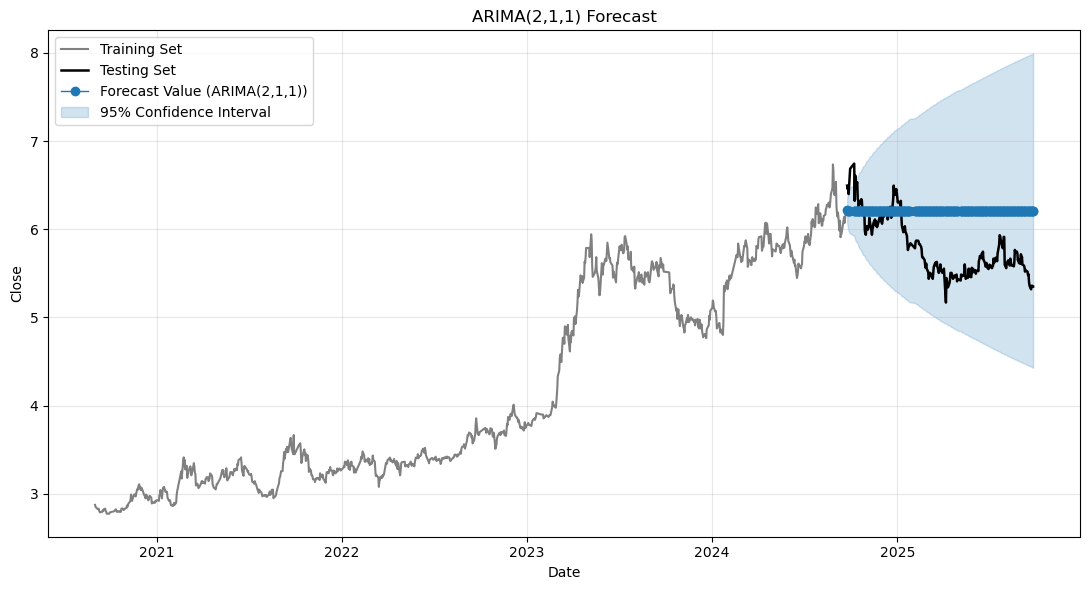

In [29]:

# 1) 读取与预处理
csv_path = "data/single_stock_data_1/600028.csv"
df = pd.read_csv(csv_path)

# 明确列名
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df = df.sort_values("Date").set_index("Date")
y = df["close"].astype(float).dropna()

# 2) 80%/20% 按时间切分
n = len(y)
h_test = max(1, int(np.ceil(0.2 * n)))
y_train = y.iloc[:-h_test]
y_test  = y.iloc[-h_test:]

print(f"样本总数: {n}；训练集: {len(y_train)}；测试集: {len(y_test)}")
print(f"训练区间: {y_train.index[0].date()} → {y_train.index[-1].date()}")
print(f"测试区间: {y_test.index[0].date()} → {y_test.index[-1].date()}")

# 3) 训练 ARIMA(2,1,1)
model = ARIMA(
    y_train,
    order=(2, 1, 1),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit()

# 4) 针对测试区间长度做多步预测
steps = len(y_test)
fc_res = model.get_forecast(steps=steps)
fc_mean = fc_res.predicted_mean
fc_ci   = fc_res.conf_int(alpha=0.05)  # 95% 置信区间

# 对齐测试区间索引（便于可视化对比）
fc_mean.index = y_test.index
fc_ci.index   = y_test.index

# 可选：查看预测表
forecast_df = pd.DataFrame({
    "Forecast": fc_mean,
    "Lower_95%": fc_ci.iloc[:, 0],
    "Upper_95%": fc_ci.iloc[:, 1]
})
print("\n测试区间逐日预测（含95%置信区间）:")
print(forecast_df.head(10))

# 5) 可视化：训练真实值 / 测试真实值 / 预测值 / 95%置信区间
plt.figure(figsize=(11, 6))
plt.plot(y_train.index, y_train, label="Training Set", color="gray", linewidth=1.5)
plt.plot(y_test.index,  y_test,  label="Testing Set", color="black", linewidth=1.8)
plt.plot(fc_mean.index, fc_mean, label="Forecast Value (ARIMA(2,1,1))", color="tab:blue", linewidth=1.0, marker="o")

# 置信区间阴影
plt.fill_between(
    fc_ci.index,
    fc_ci.iloc[:, 0],
    fc_ci.iloc[:, 1],
    color="tab:blue",
    alpha=0.20,
    label="95% Confidence Interval"
)

plt.title("ARIMA(2,1,1) Forecast")
plt.xlabel("Date")
plt.ylabel("Close")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## Future Forecasting

已加载 1232 条记录。

===== 未来 5 天预测结果 =====
            Forecast  Lower_95%  Upper_95%
2025-09-27  5.350410   5.216725   5.484095
2025-09-28  5.350381   5.173340   5.527423
2025-09-29  5.350370   5.140432   5.560307
2025-09-30  5.350371   5.111647   5.589096
2025-10-01  5.350372   5.085954   5.614789


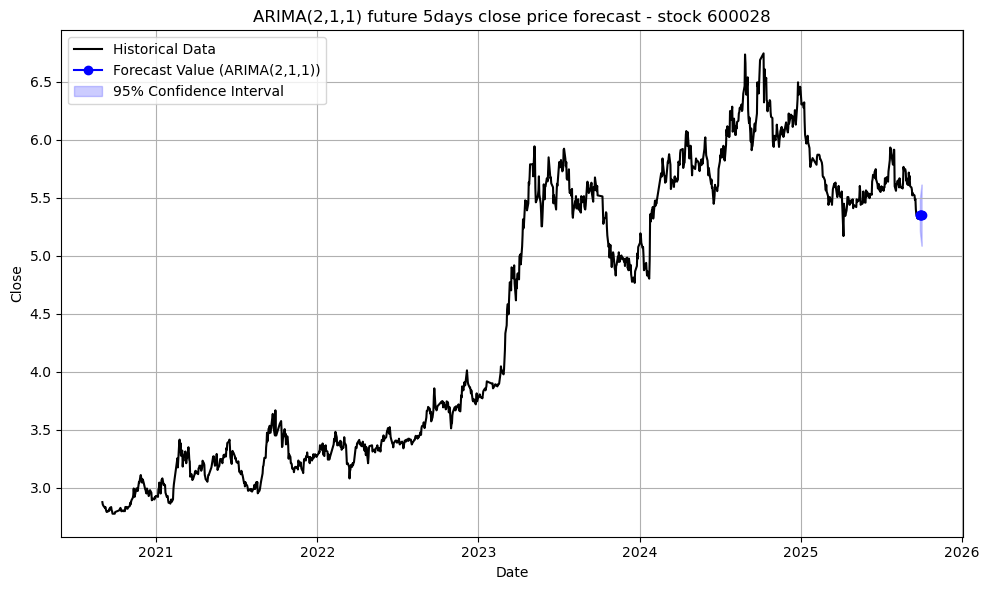

In [31]:

# 1. 读取数据
df = pd.read_csv("data/single_stock_data_1/600028.csv")

# 指定列名
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date").set_index("Date")

# 取 close 列
y = df["close"].astype(float).dropna()

print(f"已加载 {len(y)} 条记录。")

# 2. 拟合 ARIMA(2,1,1)
model = ARIMA(y, order=(2, 1, 1), enforce_stationarity=False, enforce_invertibility=False).fit()

# 3. 预测未来 5 天
forecast_steps = 5
fc = model.get_forecast(steps=forecast_steps)
fc_mean = fc.predicted_mean
fc_ci = fc.conf_int(alpha=0.05)

# 构造未来日期索引（假设为自然日）
last_date = y.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_steps, freq="D")
fc_mean.index = future_dates
fc_ci.index = future_dates

# 汇总结果
forecast_df = pd.DataFrame({
    "Forecast": fc_mean,
    "Lower_95%": fc_ci.iloc[:, 0],
    "Upper_95%": fc_ci.iloc[:, 1]
})

print("\n===== 未来 5 天预测结果 =====")
print(forecast_df)

# 4. 可视化结果
plt.figure(figsize=(10, 6))
plt.plot(y.index, y, label="Historical Data", color="black")
plt.plot(fc_mean.index, fc_mean, label="Forecast Value (ARIMA(2,1,1))", color="blue", marker="o")
plt.fill_between(fc_ci.index, fc_ci.iloc[:, 0], fc_ci.iloc[:, 1],
                 color="blue", alpha=0.2, label="95% Confidence Interval")

plt.title("ARIMA(2,1,1) future 5days close price forecast - stock 600028")
plt.xlabel("Date")
plt.ylabel("Close")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
